# Decision Tree

Implement from scratch and use it to predict [tatanic](https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset)

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sbn
import pprint

from dtree import Dtree, entropy, gini, classify

%matplotlib inline

## Data process

In [2]:
def get_title(name):
    title_search = re.search(r'([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''


def do_precess(data_set):
    '''
    数据预处理的函数，主要是：
    1. nan补全 Embarked Fare Age
    2. 连续值离散化 Age Fare
    3. 字符串数值化 Has_Cabin Title Sex Embarked
    4. 生成派生属性 IsAlone FamilySize
    5. 删除多余属性 PassengerId Name'Ticket Cabin'SibSp
    :param data_set:
    :return:
    '''
    # Cabin
    data_set['Has_Cabin'] = data_set['Cabin']. apply(
        lambda x: 0 if type(x)==float else 1)
    # FamilySize derive
    data_set['FamilySize'] = data_set['SibSp'] + data_set['Parch'] + 1
    # FamilySize  IsAlone
    data_set['IsAlone'] = 0
    data_set.loc[data_set['FamilySize'] == 1, 'IsAlone'] = 1
    # Embarked
    data_set['Embarked'] = data_set['Embarked'].fillna('S')
    data_set['Embarked'] = data_set['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    # Fare
    data_set['Fare'] = data_set['Fare'].fillna(data_set['Fare'].median())
    data_set.loc[data_set['Fare'] <= 7.91, 'Fare'] = 0
    data_set.loc[(data_set['Fare'] > 7.91) & (data_set['Fare'] <= 14.454), 'Fare'] = 1
    data_set.loc[(data_set['Fare'] > 14.454) & (data_set['Fare'] <= 31), 'Fare'] = 2
    data_set.loc[data_set['Fare'] > 31, 'Fare'] = 3
    data_set['Fare'] = data_set['Fare'].astype(int)
    #  Age
    age_avg = data_set['Age'].mean()
    age_std = data_set['Age'].std()
    age_null_count = data_set['Age'].isnull().sum()
    age_null_random_list = np.random.randint(
        age_avg - age_std, age_avg+age_std, size=age_null_count)
    data_set.loc[np.isnan(data_set['Age']), 'Age'] = age_null_random_list
    data_set['Age'] = data_set['Age'].apply(lambda x: int(x / 6)).astype(int)
    # Title
    data_set['Title'] = data_set['Name'].apply(get_title)
    data_set['Title'] = data_set['Title'].replace(
        ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data_set['Title'] = data_set['Title'].replace('Mlle', 'Miss')
    data_set['Title'] = data_set['Title'].replace('Ms', 'Miss')
    data_set['Title'] = data_set['Title'].replace('Mme', 'Mrs')
    data_set['Title'] = data_set['Title'].map(
        {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5})
    data_set['Title'] = data_set['Title'].fillna(0)
    #  Sex
    data_set['Sex'] = data_set['Sex'].map({'female': 0, 'male': 1}).astype(int)
    # Drop
    return data_set.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis=1)

In [3]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

train = do_precess(train)
test = do_precess(test)

## Relationship of each feature
Compute the correlation of each pair of features. For example, we can see that `Title` and `Sex` are strongly negatively correlated while `Parch` and `familySize` are strongly negatively correlated.

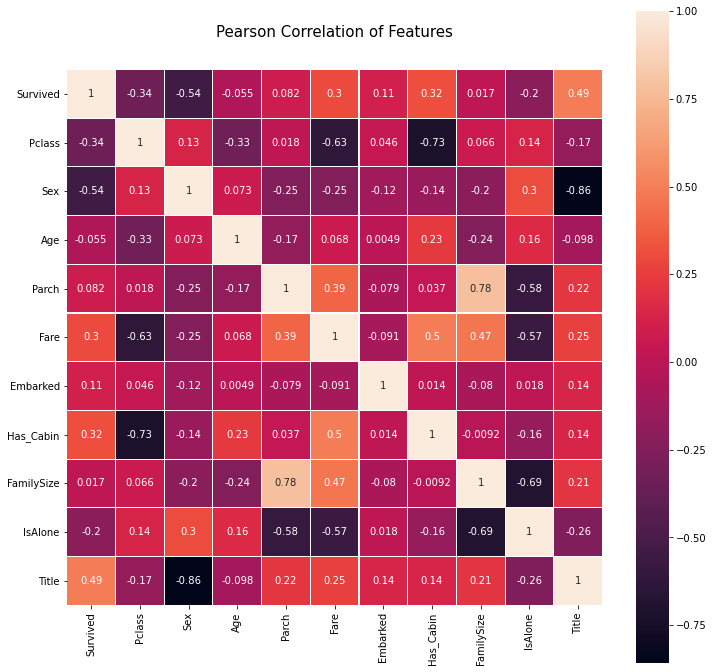

In [4]:
# 查看协方差，观察各个数据的相关系数
corr = train.astype(float).corr()
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sbn.heatmap(corr, linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

In [5]:
labels = train['Survived']
features = train.drop(['Survived'], axis=1)

total_num = len(labels)
num_train = int(total_num * 0.8)

train_feats = features.iloc[0:num_train, :]
train_labels = labels.iloc[0:num_train]
eval_feats = features.iloc[num_train:, :]
eval_labels = labels.iloc[num_train:]

dtree = Dtree(train_feats, train_labels, eval_feats, eval_labels, gini)
tree = dtree.grow()

In [13]:
preds = []
for i in range(len(eval_feats)):
    feat = dict(eval_feats.iloc[i])
    preds.append(classify(tree, feat))
preds = np.array(preds)
accuracy = np.sum(preds == eval_labels.values) / len(preds)
print('final accuracy on eval set is: ', accuracy)

final accuracy on eval set is:  0.7486033519553073


In [15]:
pprint.pprint(tree)

{'Title': {1: {'Has_Cabin': {0: {'Age': {2: (0, {0: 23, 1: 1}),
                                         3: {'Fare': {0: (0, {0: 39, 1: 2}),
                                                      1: {'FamilySize': {1: {'Pclass': {2: (0,
                                                                                            {0: 5,
                                                                                             1: 1}),
                                                                                        3: {'Embarked': {0: (0,
                                                                                                             {0: 16,
                                                                                                              1: 2}),
                                                                                                         1: (0,
                                                                                                         